In [80]:
def get_census_data() -> gpd.GeoDataFrame:
    # """Obtiene data de radios censales."""
    # # # descargar shp de https://precensodeviviendas.indec.gob.ar/descargas#
    # data_dir = os.path.join(PROJECT_DIR, "data")
    radios = gpd.read_file("data/radios.zip")
    # leemos la informacion censal de poblacion por radio
    radios = (
        radios.reindex(columns=["ind01", "nomdepto", "geometry"])
        .reset_index()
        .iloc[:, 1:]
    )
    radios.columns = ["TOTAL_VIV", "COMUNA", "geometry"]
    radios["TOTAL_VIV"] = radios.apply(lambda x: int(x["TOTAL_VIV"]), axis=1)
    return radios

In [81]:
def filter_census_data(radios: pd.DataFrame, numero_comuna: int) -> pd.DataFrame:
    """Filtra el gdf por numero de comuna.

    Parameters
    ----------
    radios : pd.DataFrame
        DataFrame con informacion geometrica de radios censales.
    numero_comuna : int
        int indicando numero de comuna.

    Returns
    -------
    pd.DataFrame
        DataFrame con informacion geometrica de radios censales para la comuna dada.
    """
    radios_filt = radios[radios["COMUNA"] == "Comuna " + str(numero_comuna)].copy()
    return radios_filt

In [82]:
def get_public_space():
#     path: str = f"{PROJECT_DIR}/data/public_space.geojson",
# ) -> gpd.GeoDataFrame:
    """Obtiene un GeoDataFrame de Espacio Verde Público de un path dado, o lo descarga.

    Parameters
    ----------
    path : str, optional
        Ubicación deseada del archivo. Si no se encuentra, se lo creará.
        por default "./data/public_space.geojson".

    Returns
    -------
    gpd.GeoDataFrame
        GeoDataFrame de espacio verde público.
    """
    # init_package(PROJECT_DIR)
    # if not os.path.exists(path):
    #     url_home = "https://cdn.buenosaires.gob.ar/"
    #     print(f"{path} no contiene un geojson, descargando de {url_home}...")
    #     url = (
    #         f"{url_home}datosabiertos/datasets/"
    #         "secretaria-de-desarrollo-urbano/espacios-verdes/"
    #         "espacio_verde_publico.geojson"
    #     )
    #     resp = requests.get(url)
    #     with open(path, "w") as f:
    #         f.write(resp.text)
    gdf = gpd.read_file("data/public_space.geojson")
    # a partir del csv y data frame, convertimos en GeoDataFrame con un crs
    gdf = gpd.GeoDataFrame(gdf, geometry="geometry", crs="epsg:4326")
    gdf = gdf.reindex(columns=["nombre", "clasificac", "area", "geometry"])
    return gdf

In [84]:
def get_bbox(comunas_idx: List[int]) -> gpd.GeoDataFrame:
    """Devuelve el bounding box para un conjunto de comunas.

    Parameters
    ----------
    comunas_idx : List[int]
        int indicando comuna idx

    Returns
    -------
    gpd.GeoDataFrame
        Lista de enteros indicando números de comuna
    """
    gdf = gpd.read_file(
        "https://storage.googleapis.com/python_mdg/carto_cursos/comunas.zip"
    )
    filtered_gdf = gdf[gdf["COMUNAS"].isin(comunas_idx)].copy().to_crs(4326)

    # limite exterior comunas
    filtered_gdf["cons"] = 0
    box = filtered_gdf.dissolve(by="cons")
    return box.total_bounds

In [340]:
radios=filter_census_data(get_census_data(), 8)

In [166]:
radios_p = radios.copy().to_crs(4326)  # FIXME: el crs rompe el Kepler
radios_p["geometry"] = geometry_centroid(radios_p)

<ipython-input-62-7c249a7a86de>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return gdf["geometry"].centroid


In [89]:
def bound_multipol_by_bbox(gdf, bbox):
    """Devuelve la interseccion entre un bounding box (bbox) y la columna
    geometry de un GeoDataFrame.

    Parameters
    ----------
    gdf : gpd.GeoDataFrame
        GeoDataFrame con informacion geometrica.
    bbox : ndarray[float]
        Array indicando los vértices de una bbox.

    Returns
    -------
    gpd.GeoDataFrame
        GeoDataFrame con la intersección entre el input y la bbox.
    """
    bb_polygon = Polygon(
        [
            (bbox[0], bbox[3]),
            (bbox[2], bbox[3]),
            (bbox[2], bbox[1]),
            (bbox[0], bbox[1]),
        ]
    )

    gdf2 = gpd.GeoDataFrame(gpd.GeoSeries(bb_polygon), columns=["geometry"])
    intersections = gpd.overlay(gdf2, gdf, how="intersection")
    return intersections

In [90]:
parques_p = bound_multipol_by_bbox(get_public_space(), get_bbox([8]))
parques_p["geometry"] = geometry_centroid(parques_p)

<ipython-input-89-fe92019172b4>:27: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  intersections = gpd.overlay(gdf2, gdf, how="intersection")


In [341]:
parques = bound_multipol_by_bbox(get_public_space(), get_bbox([8]))

<ipython-input-89-fe92019172b4>:27: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  intersections = gpd.overlay(gdf2, gdf, how="intersection")


In [342]:
parques

,nombre,clasificac,area,geometry
0,NaN,CANTERO CENTRAL,858.057,"POLYGON ((-58.47669 -34.65452, -58.47661 -34.6..."
1,Irma Carrica,CANTERO CENTRAL,1126.353,"POLYGON ((-58.47567 -34.65481, -58.47568 -34.6..."
2,NaN,CANTERO CENTRAL,11259.719,"MULTIPOLYGON (((-58.44278 -34.66878, -58.44281..."
3,NaN,CANTERO CENTRAL,2790.612,"MULTIPOLYGON (((-58.44089 -34.66691, -58.44089..."
4,Martín Boneo y Villalonga,CANTERO CENTRAL,2043.584,"MULTIPOLYGON (((-58.47162 -34.65536, -58.47159..."
...,...,...,...,...
439,Cancha de Lorenza,PLAZA,438.317,"POLYGON ((-58.46240 -34.67229, -58.46233 -34.6..."
440,NaN,PLAZOLETA,515.709,"MULTIPOLYGON (((-58.47351 -34.66013, -58.47349..."
441,NaN,CANTERO CENTRAL,6080.637,"POLYGON ((-58.47245 -34.66264, -58.47247 -34.6..."
442,NaN,PLAZOLETA,1045.094,"MULTIPOLYGON (((-58.45295 -34.65082, -58.45295..."


In [235]:
parques_p

,nombre,clasificac,area,geometry
0,NaN,CANTERO CENTRAL,858.057,POINT (-58.47677 -34.65455)
1,Irma Carrica,CANTERO CENTRAL,1126.353,POINT (-58.47584 -34.65468)
2,NaN,CANTERO CENTRAL,11259.719,POINT (-58.44408 -34.67019)
3,NaN,CANTERO CENTRAL,2790.612,POINT (-58.44173 -34.66763)
4,Martín Boneo y Villalonga,CANTERO CENTRAL,2043.584,POINT (-58.47217 -34.65537)
...,...,...,...,...
439,Cancha de Lorenza,PLAZA,438.317,POINT (-58.46233 -34.67234)
440,NaN,PLAZOLETA,515.709,POINT (-58.47355 -34.66030)
441,NaN,CANTERO CENTRAL,6080.637,POINT (-58.47080 -34.65891)
442,NaN,PLAZOLETA,1045.094,POINT (-58.45305 -34.65085)


In [95]:
parques_p.groupby('clasificac')['area'].mean()

clasificac
BARRIO/COMPLEJO               91923.954000
CANTERO CENTRAL                2659.509837
PARQUE                       333870.962778
PATIO DE JUEGOS INCLUSIVO       218.057000
PATIO RECREATIVO               2516.185000
PLAZA                          5435.111226
PLAZOLETA                     10524.210160
Name: area, dtype: float64

In [177]:
get_public_space().nombre.value_counts()

Cancha auxiliar abierta - Club Atl. Boca Juniors       2
Plaza José Martí                                       2
Escuela Scalabrini Ortiz                               1
Bosque Alegre (Depvo. M. Belgrano)                     1
Av. 9 de Julio                                         1
                                                      ..
Alejandro Petión                                       1
Orencio P. Rodríguez                                   1
Plazoleta Gelly y Obes                                 1
C. González Pecotche                                   1
Paseo del Ballet Argentino (e/ Gutenberg y Mistral)    1
Name: nombre, Length: 1002, dtype: int64

In [175]:
radios

,TOTAL_VIV,COMUNA,geometry
10525,193,Comuna 8,"POLYGON ((-58.49171 -34.67420, -58.49128 -34.6..."
15423,369,Comuna 8,"POLYGON ((-58.47987 -34.67288, -58.48108 -34.6..."
15561,310,Comuna 8,"POLYGON ((-58.47849 -34.67172, -58.47946 -34.6..."
19394,234,Comuna 8,"POLYGON ((-58.46650 -34.67597, -58.46677 -34.6..."
20274,374,Comuna 8,"POLYGON ((-58.47223 -34.68096, -58.47288 -34.6..."
...,...,...,...
38657,260,Comuna 8,"POLYGON ((-58.45356 -34.65832, -58.45393 -34.6..."
38686,236,Comuna 8,"POLYGON ((-58.45306 -34.65875, -58.45327 -34.6..."
38700,364,Comuna 8,"POLYGON ((-58.45448 -34.66241, -58.45441 -34.6..."
38715,270,Comuna 8,"POLYGON ((-58.45531 -34.66494, -58.45511 -34.6..."


In [226]:
from shapely.geometry import MultiPolygon

In [170]:
type(get_public_space().iloc[0,-1])

shapely.geometry.multipolygon.MultiPolygon

In [109]:
type(get_public_space().iloc[1,-1])

shapely.geometry.multipolygon.MultiPolygon

In [224]:
list_polygons=list(get_public_space().iloc[:,-1])

In [231]:
len(list(get_public_space().iloc[:,-1]))

1765

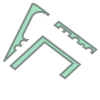

In [229]:
list_polygons[0]

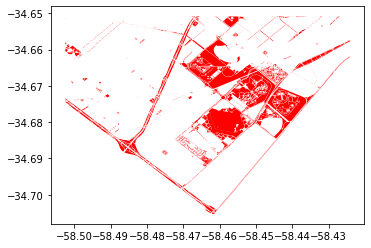

In [343]:
from shapely.ops import unary_union
polygons = list(parques.iloc[:,-1])
boundary = gpd.GeoSeries(unary_union(polygons))
boundary.plot(color = 'red')
plt.show()

In [239]:
boundary

0    MULTIPOLYGON (((-58.49730 -34.67781, -58.49348...
dtype: geometry

In [242]:
radios.geometry.shape[0]

191

In [255]:
type(boundary)

geopandas.geoseries.GeoSeries

In [274]:
boundary

,geometry
0,"MULTIPOLYGON (((-58.49730 -34.67781, -58.49348..."


In [283]:
radios.iloc[:1,]

,TOTAL_VIV,COMUNA,geometry
10525,193,Comuna 8,"POLYGON ((-58.49171 -34.67420, -58.49128 -34.6..."


In [289]:
radios.shape[0]

191

In [292]:
for i in range(1,radios.shape[0]):
    gpd.overlay(radios.iloc[i:i+1,], boundary, how="intersection")

<ipython-input-292-4425a615d356>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...
Right CRS: None

  gpd.overlay(radios.iloc[i:i+1,], boundary, how="intersection")
<ipython-input-292-4425a615d356>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...
Right CRS: None

  gpd.overlay(radios.iloc[i:i+1,], boundary, how="intersection")
<ipython-input-292-4425a615d356>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID[

In [307]:
radios.reset_index()

,index,TOTAL_VIV,COMUNA,geometry
0,10525,193,Comuna 8,"POLYGON ((-58.49171 -34.67420, -58.49128 -34.6..."
1,15423,369,Comuna 8,"POLYGON ((-58.47987 -34.67288, -58.48108 -34.6..."
2,15561,310,Comuna 8,"POLYGON ((-58.47849 -34.67172, -58.47946 -34.6..."
3,19394,234,Comuna 8,"POLYGON ((-58.46650 -34.67597, -58.46677 -34.6..."
4,20274,374,Comuna 8,"POLYGON ((-58.47223 -34.68096, -58.47288 -34.6..."
...,...,...,...,...
186,38657,260,Comuna 8,"POLYGON ((-58.45356 -34.65832, -58.45393 -34.6..."
187,38686,236,Comuna 8,"POLYGON ((-58.45306 -34.65875, -58.45327 -34.6..."
188,38700,364,Comuna 8,"POLYGON ((-58.45448 -34.66241, -58.45441 -34.6..."
189,38715,270,Comuna 8,"POLYGON ((-58.45531 -34.66494, -58.45511 -34.6..."


<ipython-input-310-bcce37c105bf>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...
Right CRS: None

  df=pd.merge(radios.reset_index(),gpd.overlay(radios.reset_index().iloc[:,], boundary, how="intersection"),on='index',how='left')


In [316]:
df.head()

,index,TOTAL_VIV_x,COMUNA_x,geometry_x,TOTAL_VIV_y,COMUNA_y,geometry_y
0,10525,193,Comuna 8,"POLYGON ((-58.49171 -34.67420, -58.49128 -34.6...",NaN,NaN,None
1,15423,369,Comuna 8,"POLYGON ((-58.47987 -34.67288, -58.48108 -34.6...",NaN,NaN,None
2,15561,310,Comuna 8,"POLYGON ((-58.47849 -34.67172, -58.47946 -34.6...",310.0,Comuna 8,"MULTIPOLYGON (((-58.47849 -34.67071, -58.47849..."
3,19394,234,Comuna 8,"POLYGON ((-58.46650 -34.67597, -58.46677 -34.6...",NaN,NaN,None
4,20274,374,Comuna 8,"POLYGON ((-58.47223 -34.68096, -58.47288 -34.6...",NaN,NaN,None


<ipython-input-324-3b6e6f8bb8b7>:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['area_ps_rc']=df.geometry_ps_rc.area


<ipython-input-89-fe92019172b4>:27: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  intersections = gpd.overlay(gdf2, gdf, how="intersection")


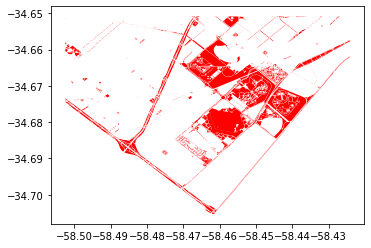

<ipython-input-380-da302e7d164e>:9: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...
Right CRS: None

  df=pd.merge(radios.reset_index(),gpd.overlay(radios.reset_index().iloc[:,], boundary, how="intersection"),on='index',how='left')
<ipython-input-380-da302e7d164e>:13: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['area_ps_rc']=df.geometry_ps_rc.area


In [380]:
radios=filter_census_data(get_census_data(), 8)
parques = bound_multipol_by_bbox(get_public_space(), get_bbox([8]))
from shapely.ops import unary_union
polygons = list(parques.iloc[:,-1])
boundary = gpd.GeoSeries(unary_union(polygons))
boundary.plot(color = 'red')
plt.show()
boundary=gpd.GeoDataFrame(geometry=gpd.GeoSeries(boundary))
df=pd.merge(radios.reset_index(),gpd.overlay(radios.reset_index().iloc[:,], boundary, how="intersection"),on='index',how='left')
df=df.loc[:,['index', 'TOTAL_VIV_x', 'COMUNA_x', 'geometry_x','geometry_y']]
df.columns=['index', 'TOTAL_VIV', 'COMUNA', 'geometry_radio', 'geometry_ps_rc']
df['TOTAL_VIV']=df['TOTAL_VIV']+1
df['area_ps_rc']=df.geometry_ps_rc.area
df['area_ps_rc'].fillna(0,inplace=True)
df['ratio']=df['area_ps_rc']/df['TOTAL_VIV']

<Axes: >

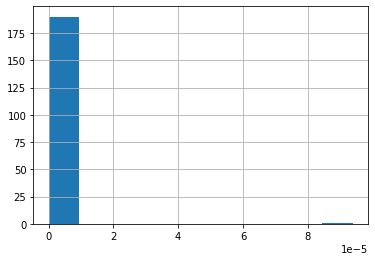

In [355]:
df['ratio'].hist()

In [356]:
df['ratio'][df['ratio']<2]

0      0.000000e+00
1      0.000000e+00
2      6.754135e-10
3      0.000000e+00
4      0.000000e+00
           ...     
186    0.000000e+00
187    2.893112e-10
188    2.202571e-11
189    0.000000e+00
190    1.223529e-10
Name: ratio, Length: 191, dtype: float64

<ipython-input-269-6d4dc7a3ce28>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...
Right CRS: None

  gpd.overlay(radios, boundary, how="intersection").plot()


<Axes: >

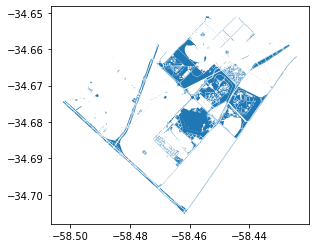

In [269]:
 gpd.overlay(radios, boundary, how="intersection").plot()

In [268]:
radios

,TOTAL_VIV,COMUNA,geometry
10525,193,Comuna 8,"POLYGON ((-58.49171 -34.67420, -58.49128 -34.6..."
15423,369,Comuna 8,"POLYGON ((-58.47987 -34.67288, -58.48108 -34.6..."
15561,310,Comuna 8,"POLYGON ((-58.47849 -34.67172, -58.47946 -34.6..."
19394,234,Comuna 8,"POLYGON ((-58.46650 -34.67597, -58.46677 -34.6..."
20274,374,Comuna 8,"POLYGON ((-58.47223 -34.68096, -58.47288 -34.6..."
...,...,...,...
38657,260,Comuna 8,"POLYGON ((-58.45356 -34.65832, -58.45393 -34.6..."
38686,236,Comuna 8,"POLYGON ((-58.45306 -34.65875, -58.45327 -34.6..."
38700,364,Comuna 8,"POLYGON ((-58.45448 -34.66241, -58.45441 -34.6..."
38715,270,Comuna 8,"POLYGON ((-58.45531 -34.66494, -58.45511 -34.6..."


In [250]:
GeoDataFrame(radios)

NameError: name 'GeoDataFrame' is not defined

In [249]:
 gpd.overlay(radios.iloc[1,], boundary, how="intersection")

NotImplementedError: overlay currently only implemented for GeoDataFrames

In [248]:
for i in radios.geometry.shape[0]:
    gpd.overlay(radios.iloc[1,], boundary, how="intersection")
    

TypeError: 'int' object is not iterable

In [ ]:
intersections = gpd.overlay(gdf2, gdf, how="intersection")

In [227]:
import shapely.geometry as geom
polygons = [wkt.loads(wkt_string) for wkt_string in list_polygons]
multi_polygon = geom.MultiPolygon(polygons)

TypeError: Expected bytes or string, got MultiPolygon

In [223]:
multipolygon = MultiPolygon(list(get_public_space().geometry))

# create a new GeoDataFrame with a single row containing the multipolygon
new_gdf = gpd.GeoDataFrame(geometry=[multipolygon])


ValueError: Sequences of multi-polygons are not valid arguments

In [173]:
intersection_gdf = gpd.overlay(get_public_space(), radios, how='intersection')


<ipython-input-173-12c641326d50>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...

  intersection_gdf = gpd.overlay(get_public_space(), radios, how='intersection')


In [181]:
joined_gdf = gpd.sjoin(get_public_space(), radios, how='inner', op='within')

/Users/fabriciodiana/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-181-1fc71d2aa2a9>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...

  joined_gdf = gpd.sjoin(get_public_space(), radios, how='inner', op='within')


In [186]:
gb_joined_gdf=joined_gdf.groupby('index_right')["area"].sum()

In [192]:
gb_joined_gdf=pd.DataFrame(gb_joined_gdf).reset_index()

In [195]:
gb_joined_gdf.columns=['index', 'area']

In [197]:
public_sp_cens=pd.merge(radios.reset_index(),gb_joined_gdf, on="index",how='outer')

In [200]:
public_sp_cens.fillna(0,inplace=True)

In [204]:
public_sp_cens['m2_hab']=public_sp_cens['area']/public_sp_cens['TOTAL_VIV']

In [208]:
from keplergl import KeplerGl

In [209]:
from streamlit_keplergl import keplergl_static

In [206]:
def plot_kepler(self, data: gpd.GeoDataFrame) -> None:
        map_1 = KeplerGl(height=500, data={"data": data}, config=self.config)
        keplergl_static(map_1)
        map_1.add_data(data=data, name="radios")

In [218]:
from matplotlib import pyplot as plt

In [220]:
public_sp_cens.m2_hab.describe()

count    185.000000
mean            inf
std             NaN
min        0.000000
25%        0.000000
50%        0.000000
75%        1.507664
max             inf
Name: m2_hab, dtype: float64

In [379]:

boundary=gpd.GeoDataFrame(geometry=gpd.GeoSeries(boundary))
df=pd.merge(radios.reset_index(),gpd.overlay(radios.reset_index().iloc[:,], boundary, how="intersection"),on='index',how='left')
df=df.loc[:,['index', 'TOTAL_VIV_x', 'COMUNA_x', 'geometry_x','geometry_y']]
df.columns=['index', 'TOTAL_VIV', 'COMUNA', 'geometry_radio', 'geometry_ps_rc']
df['area_ps_rc']=df.geometry_ps_rc.area
df['area_ps_rc'].fillna(0,inplace=True)
df['ratio']=df['area_ps_rc']/df['TOTAL_VIV']

ValueError: The truth value of a GeoDataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [381]:
df.TOTAL_VIV=df.TOTAL_VIV+1

In [382]:
df['geometry']=df['geometry_radio']

In [383]:
import numpy as np

In [389]:
df.head()

,index,TOTAL_VIV,COMUNA,geometry_radio,geometry_ps_rc,area_ps_rc,ratio,geometry
0,10525,195,Comuna 8,"POLYGON ((-58.49171 -34.67420, -58.49128 -34.6...",None,0.000000e+00,0.000000e+00,"POLYGON ((-58.49171 -34.67420, -58.49128 -34.6..."
1,15423,371,Comuna 8,"POLYGON ((-58.47987 -34.67288, -58.48108 -34.6...",None,0.000000e+00,0.000000e+00,"POLYGON ((-58.47987 -34.67288, -58.48108 -34.6..."
2,15561,312,Comuna 8,"POLYGON ((-58.47849 -34.67172, -58.47946 -34.6...","MULTIPOLYGON (((-58.47849 -34.67071, -58.47849...",2.100536e-07,6.754135e-10,"POLYGON ((-58.47849 -34.67172, -58.47946 -34.6..."
3,19394,236,Comuna 8,"POLYGON ((-58.46650 -34.67597, -58.46677 -34.6...",None,0.000000e+00,0.000000e+00,"POLYGON ((-58.46650 -34.67597, -58.46677 -34.6..."
4,20274,376,Comuna 8,"POLYGON ((-58.47223 -34.68096, -58.47288 -34.6...",None,0.000000e+00,0.000000e+00,"POLYGON ((-58.47223 -34.68096, -58.47288 -34.6..."


<Axes: >

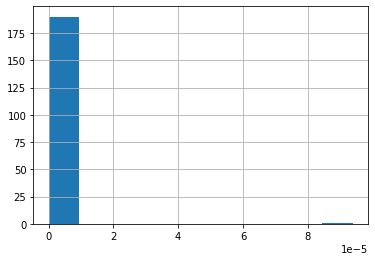

In [391]:
df.ratio.hist()

In [399]:
df_red=(df[(df['ratio']<2*10**(-5))&(df['ratio']>0)])

<Axes: >

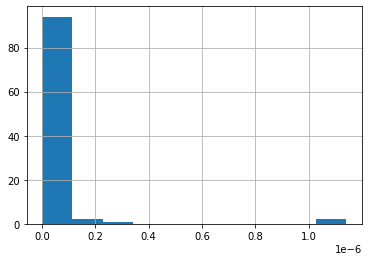

In [400]:
df_red.ratio.hist()

In [401]:
df_red['log_ratio']=np.log(df_red['ratio'])

/Users/fabriciodiana/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

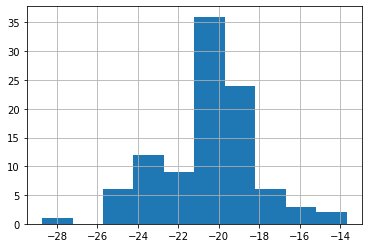

In [402]:
df_red['log_ratio'].hist()

<Axes: >

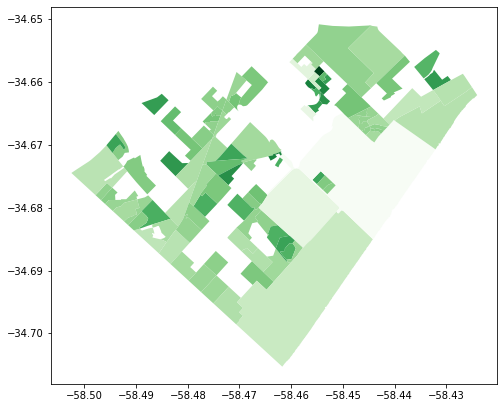

In [403]:
f, ax = plt.subplots(1,figsize=(8,8))
df_red.plot(column='log_ratio',cmap='Greens_r', ax=ax)

In [215]:
map_1 = KeplerGl(height=500, data=public_sp_cens)


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


TraitError: The 'data' trait of a KeplerGl instance expected a dict, not the GeoDataFrame      index  TOTAL_VIV    COMUNA  \
0    10525        193  Comuna 8   
1    15423        369  Comuna 8   
2    15561        310  Comuna 8   
3    19394        234  Comuna 8   
4    20274        374  Comuna 8   
..     ...        ...       ...   
186  38657        260  Comuna 8   
187  38686        236  Comuna 8   
188  38700        364  Comuna 8   
189  38715        270  Comuna 8   
190  38731        310  Comuna 8   

                                              geometry      area    m2_hab  
0    POLYGON ((-58.49171 -34.67420, -58.49128 -34.6...     0.000  0.000000  
1    POLYGON ((-58.47987 -34.67288, -58.48108 -34.6...     0.000  0.000000  
2    POLYGON ((-58.47849 -34.67172, -58.47946 -34.6...  2135.738  6.889477  
3    POLYGON ((-58.46650 -34.67597, -58.46677 -34.6...     0.000  0.000000  
4    POLYGON ((-58.47223 -34.68096, -58.47288 -34.6...     0.000  0.000000  
..                                                 ...       ...       ...  
186  POLYGON ((-58.45356 -34.65832, -58.45393 -34.6...     0.000  0.000000  
187  POLYGON ((-58.45306 -34.65875, -58.45327 -34.6...     0.000  0.000000  
188  POLYGON ((-58.45448 -34.66241, -58.45441 -34.6...     0.000  0.000000  
189  POLYGON ((-58.45531 -34.66494, -58.45511 -34.6...     0.000  0.000000  
190  POLYGON ((-58.45618 -34.66109, -58.45604 -34.6...     0.000  0.000000  

[191 rows x 6 columns].

In [211]:
plot_kepler(data=public_sp_cens)

TypeError: plot_kepler() missing 1 required positional argument: 'self'

In [216]:
public_sp_cens

,index,TOTAL_VIV,COMUNA,geometry,area,m2_hab
0,10525,193,Comuna 8,"POLYGON ((-58.49171 -34.67420, -58.49128 -34.6...",0.000,0.000000
1,15423,369,Comuna 8,"POLYGON ((-58.47987 -34.67288, -58.48108 -34.6...",0.000,0.000000
2,15561,310,Comuna 8,"POLYGON ((-58.47849 -34.67172, -58.47946 -34.6...",2135.738,6.889477
3,19394,234,Comuna 8,"POLYGON ((-58.46650 -34.67597, -58.46677 -34.6...",0.000,0.000000
4,20274,374,Comuna 8,"POLYGON ((-58.47223 -34.68096, -58.47288 -34.6...",0.000,0.000000
...,...,...,...,...,...,...
186,38657,260,Comuna 8,"POLYGON ((-58.45356 -34.65832, -58.45393 -34.6...",0.000,0.000000
187,38686,236,Comuna 8,"POLYGON ((-58.45306 -34.65875, -58.45327 -34.6...",0.000,0.000000
188,38700,364,Comuna 8,"POLYGON ((-58.45448 -34.66241, -58.45441 -34.6...",0.000,0.000000
189,38715,270,Comuna 8,"POLYGON ((-58.45531 -34.66494, -58.45511 -34.6...",0.000,0.000000


In [212]:
self.plot_kepler(public_sp_cens)

NameError: name 'self' is not defined

<Axes: >

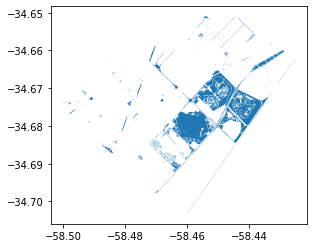

In [183]:
joined_gdf.plot()

<Axes: >

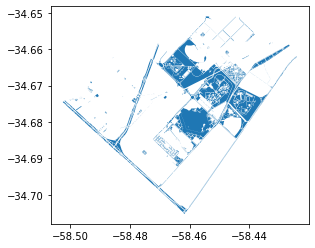

In [178]:
intersection_gdf.plot()

In [176]:
intersection_gdf.nombre.value_counts()

Gral. Paz                                 14
Barrio Municipal Soldati                  10
Parque Indoamericano                       7
Boulevard Olímpico (no oficial)            4
Cantero Av 27 de Febrero (y Pergamino)     2
                                          ..
Mayor Bernardo Alberte                     1
Irene Bernasconi                           1
Plaza Nicolás Granada                      1
Plaza Unidad Nacional                      1
Cancha de Lorenza                          1
Name: nombre, Length: 78, dtype: int64

In [120]:
from shapely import wkt

In [125]:
import shapely.geometry as geom
polygons = [wkt.loads(wkt_string) for (wkt_string) in list(radios.iloc[:3,-1])]
multi_polygon = geom.MultiPolygon(polygons)

TypeError: Expected bytes or string, got Polygon

In [128]:
str(list(radios.iloc[:,-1])[0])

'POLYGON ((-58.491708755912356 -34.674196840495604, -58.4912797013874 -34.67463244528904, -58.49106726121297 -34.67484806380959, -58.48997111094575 -34.675921507871294, -58.49035897324257 -34.67616227174277, -58.490711903633205 -34.676196135397184, -58.490867832786826 -34.67623673412301, -58.491105804541974 -34.67638583760362, -58.491204318032636 -34.67654173402954, -58.49121262164754 -34.67664342419107, -58.491188038940514 -34.6767993493538, -58.49099117655861 -34.67696890637153, -58.49088447103675 -34.67703667894656, -58.49065474420936 -34.67707743680857, -58.49036491034835 -34.67735060820174, -58.490880634631644 -34.67779078258652, -58.4911239165138 -34.67799847679003, -58.49126794165991 -34.67811964394026, -58.492019364269936 -34.67752684583121, -58.49178725397091 -34.67733478422959, -58.49241074625683 -34.67683976243788, -58.492385998802845 -34.67652786022575, -58.49332415504501 -34.67565591657867, -58.491708755912356 -34.674196840495604))'

In [135]:
import shapely.wkt
import shapely.geometry

list_wkt = list(radios.iloc[:,-1])
list_polygons =  [shapely.wkt.loads(str(poly)) for poly in list_wkt]

print( shapely.geometry.MultiPolygon(list_polygons) )

MULTIPOLYGON (((-58.491708755912356 -34.674196840495604, -58.4912797013874 -34.67463244528904, -58.49106726121297 -34.67484806380959, -58.48997111094575 -34.675921507871294, -58.49035897324257 -34.67616227174277, -58.490711903633205 -34.676196135397184, -58.490867832786826 -34.67623673412301, -58.491105804541974 -34.67638583760362, -58.491204318032636 -34.67654173402954, -58.49121262164754 -34.67664342419107, -58.491188038940514 -34.6767993493538, -58.49099117655861 -34.67696890637153, -58.49088447103675 -34.67703667894656, -58.49065474420936 -34.67707743680857, -58.49036491034835 -34.67735060820174, -58.490880634631644 -34.67779078258652, -58.4911239165138 -34.67799847679003, -58.49126794165991 -34.67811964394026, -58.492019364269936 -34.67752684583121, -58.49178725397091 -34.67733478422959, -58.49241074625683 -34.67683976243788, -58.492385998802845 -34.67652786022575, -58.49332415504501 -34.67565591657867, -58.491708755912356 -34.674196840495604)), ((-58.47986945854245 -34.6728846145

In [155]:
type(gpd.GeoSeries(list_polygons))

geopandas.geoseries.GeoSeries

In [160]:
shapely.geometry.MultiPolygon((list_polygons[0]))

TypeError: 'Polygon' object is not iterable

In [154]:
gpd.GeoSeries(list_polygons).apply(lambda x: shapely.geometry.MultiPolygon(x))

TypeError: 'Polygon' object is not iterable

In [145]:
list_multipol=shapely.geometry.MultiPolygon(list_polygons)

ValueError: The truth value of a GeoSeries is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [139]:
radios_mult = gpd.GeoDataFrame(gpd.GeoSeries(list_multipol), columns=["geometry"])

In [146]:
radios['geometry']=radios_mult

/Users/fabriciodiana/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1442: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


In [147]:
radios_mult

,geometry
0,"MULTIPOLYGON (((-58.49171 -34.67420, -58.49128..."


In [143]:
radios

,TOTAL_VIV,COMUNA,geometry
10525,193,Comuna 8,None
15423,369,Comuna 8,None
15561,310,Comuna 8,None
19394,234,Comuna 8,None
20274,374,Comuna 8,None
...,...,...,...
38657,260,Comuna 8,None
38686,236,Comuna 8,None
38700,364,Comuna 8,None
38715,270,Comuna 8,None


In [140]:
radios_mult

,geometry
0,"MULTIPOLYGON (((-58.49171 -34.67420, -58.49128..."


In [161]:
gpd.overlay(list_multipol,get_public_space().iloc[1,-1],how="intersection")

AttributeError: 'MultiPolygon' object has no attribute 'crs'

In [104]:
gdf2 = gpd.GeoDataFrame(gpd.GeoSeries(get_public_space().geometry), columns=["geometry"])

In [ ]:
get_public_space(

In [105]:
gdf2 = gpd.GeoDataFrame(gpd.GeoSeries(get_public_space().geometry), columns=["geometry"])
for i in gdf2:
    gpd.overlay(radios, i, how="intersection")
    print(i)

    

AttributeError: 'str' object has no attribute 'crs'

In [115]:
type(radios.iloc[0,-1])

shapely.geometry.polygon.Polygon

In [ ]:
#leemos la informacion censal de poblacion por radio
radios = gpd.read_file('../data/informacion_censal_por_radio_2010.shp')
#calculamos la densidad poblaciona l como parametro de interes
radios['densidad'] = radios.TOTAL_POB / (radios.geometry.area / 1000)
#seleccionamos los atributos de interes
radios = radios.reindex(columns=[ 'CO_FRAC_RA', 'COMUNA','TOTAL_POB','densidad','geometry'])
#radios.to_file('radios')

In [ ]:
MOVILITY_TYPES = {"Walk": 5, "Car": 25, "Bike": 10, "Public Transport": 15}
def availability(self) -> None:  # TODO: Cache
    with st.container():
        col1, col2 = st.columns([1, 3])
        with col1:
            st.markdown(
                "<h3 style='text-align: left'>Typology</h3>",
                unsafe_allow_html=True,
            )
            st.write(parques_p.columns)
            st.write(get_public_space())
            print(parques_p.columns)
            park_types = parques_p.clasificac.unique()
            mask_dict = {}
            for park_type in park_types:
                mask_dict[park_type] = st.checkbox(
                    park_type.replace("/", " / "), True
                )
                    # bool_mask = parques_p.clasificac.map(mask_dict)
            st.markdown("----")
            st.markdown(
                "<h3 style='text-align: left'>Mode</h3>",
                unsafe_allow_html=True,
            )
            movility_type = st.radio(
                "Mode", MOVILITY_TYPES.keys(), label_visibility="collapsed"
            )
            speed = MOVILITY_TYPES[movility_type]
        with col2:
            st.markdown(
                "<h1 style='text-align: center'>Radios Censales</h1>",
                unsafe_allow_html=True,
            )
            self.plot_kepler(radios)
        
    with st.container():
    col1, col2 = st.columns(2)
    # Curva de población según minutos de caminata
    with col1:
        fig, _ = self.plot_curva_pob_min_cam(radios_p.distancia, speed=speed)
        st.pyplot(fig)
    # Curva de poblacion segun area del espacio
    with col2:
        fig, _ = self.plot_curva_caminata_area(
            radios_p.geometry, parques_p, speed=speed
        )
        st.pyplot(fig)


